## Lesson 1

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-beta1


In [2]:
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope = 0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype = "float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)
# Update with noise
series += noise(time, noise_level, seed = 42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                           strides = 1, padding = "causal",
                           activation = "relu",
                           input_shape = [None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
8/8 [==============================] - 25s 3s/step - loss: 73.2800 - mae: 73.6896
Epoch 2/100
8/8 [==============================] - 1s 152ms/step - loss: 72.5471 - mae: 72.9788
Epoch 3/100
8/8 [==============================] - 1s 151ms/step - loss: 71.3986 - mae: 71.8386
Epoch 4/100
8/8 [==============================] - 1s 154ms/step - loss: 69.9652 - mae: 70.4125
Epoch 5/100
8/8 [==============================] - 1s 165ms/step - loss: 68.2942 - mae: 68.7483
Epoch 6/100
8/8 [==============================] - 1s 180ms/step - loss: 66.3956 - mae: 66.8575
Epoch 7/100
8/8 [==============================] - 1s 172ms/step - loss: 64.2604 - mae: 64.7319
Epoch 8/100
8/8 [==============================] - 1s 150ms/step - loss: 61.8746 - mae: 62.3584
Epoch 9/100
8/8 [==============================] - 1s 146ms/step - loss: 59.2152 - mae: 59.7167
Epoch 10/100
8/8 [==========================

8/8 [==============================] - 1s 155ms/step - loss: 36.6179 - mae: 37.1073
Epoch 19/100
8/8 [==============================] - 1s 185ms/step - loss: 35.0338 - mae: 35.5276
Epoch 20/100
8/8 [==============================] - 1s 137ms/step - loss: 33.5630 - mae: 34.0603
Epoch 21/100
8/8 [==============================] - 1s 102ms/step - loss: 32.2391 - mae: 32.7406
Epoch 22/100
8/8 [==============================] - 1s 101ms/step - loss: 31.0315 - mae: 31.5359
Epoch 23/100
8/8 [==============================] - 1s 95ms/step - loss: 29.9012 - mae: 30.4091
Epoch 24/100
8/8 [==============================] - 1s 101ms/step - loss: 28.7990 - mae: 29.3113
Epoch 25/100
8/8 [==============================] - 1s 100ms/step - loss: 27.6928 - mae: 28.2107
Epoch 26/100
8/8 [==============================] - 1s 99ms/step - loss: 26.5612 - mae: 27.0841
Epoch 27/100
8/8 [==============================] - 1s 102ms/step - loss: 25.3985 - mae: 25.9263
Epoch 28/100
8/8 [===========================

[1e-08, 0.0001, 0, 30]

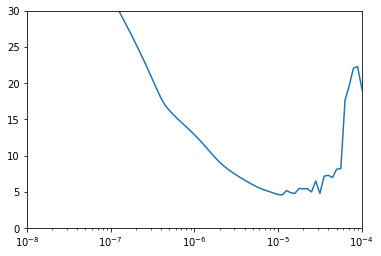

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters = 32, kernel_size = 3,
                      strides = 1, padding = "causal",
                      activation = "relu",
                      input_shape = [None, 1]),
  tf.keras.layers.LSTM(32, return_sequences = True),
  tf.keras.layers.LSTM(32, return_sequences = True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
history = model.fit(dataset, epochs = 500)

Epoch 1/500
31/31 [==============================] - 7s 212ms/step - loss: 21.5713 - mae: 22.3311
Epoch 2/500
31/31 [==============================] - 1s 40ms/step - loss: 8.4089 - mae: 8.8995
Epoch 3/500
31/31 [==============================] - 1s 39ms/step - loss: 6.7414 - mae: 7.2162
Epoch 4/500
31/31 [==============================] - 1s 38ms/step - loss: 6.2969 - mae: 6.7814
Epoch 5/500
31/31 [==============================] - 1s 39ms/step - loss: 5.7621 - mae: 6.2354
Epoch 6/500
31/31 [==============================] - 1s 38ms/step - loss: 5.6837 - mae: 6.1573
Epoch 7/500
31/31 [==============================] - 1s 39ms/step - loss: 5.4818 - mae: 5.9582
Epoch 8/500
31/31 [==============================] - 1s 38ms/step - loss: 5.3723 - mae: 5.8397
Epoch 9/500
31/31 [==============================] - 1s 39ms/step - loss: 5.3872 - mae: 5.8626
Epoch 10/500
31/31 [==============================] - 1s 39ms/step - loss: 5.2176 - mae: 5.6916
Epoch 11/500
31/31 [==========================

31/31 [==============================] - 2s 60ms/step - loss: 4.3837 - mae: 4.8466
Epoch 55/500
31/31 [==============================] - 2s 63ms/step - loss: 4.3798 - mae: 4.8424
Epoch 56/500
31/31 [==============================] - 2s 60ms/step - loss: 4.3767 - mae: 4.8391
Epoch 57/500
31/31 [==============================] - 2s 59ms/step - loss: 4.3747 - mae: 4.8369
Epoch 58/500
31/31 [==============================] - 2s 63ms/step - loss: 4.3733 - mae: 4.8353
Epoch 59/500
31/31 [==============================] - 2s 59ms/step - loss: 4.3721 - mae: 4.8341
Epoch 60/500
31/31 [==============================] - 2s 63ms/step - loss: 4.3708 - mae: 4.8327
Epoch 61/500
31/31 [==============================] - 2s 58ms/step - loss: 4.3694 - mae: 4.8314
Epoch 62/500
31/31 [==============================] - 2s 63ms/step - loss: 4.3678 - mae: 4.8297
Epoch 63/500
31/31 [==============================] - 2s 61ms/step - loss: 4.3658 - mae: 4.8276
Epoch 64/500
31/31 [==============================] -

31/31 [==============================] - 2s 57ms/step - loss: 4.2185 - mae: 4.6796
Epoch 140/500
31/31 [==============================] - 2s 56ms/step - loss: 4.2170 - mae: 4.6782
Epoch 141/500
31/31 [==============================] - 2s 58ms/step - loss: 4.2155 - mae: 4.6768
Epoch 142/500
31/31 [==============================] - 2s 62ms/step - loss: 4.2141 - mae: 4.6753
Epoch 143/500
31/31 [==============================] - 2s 57ms/step - loss: 4.2127 - mae: 4.6740
Epoch 144/500
31/31 [==============================] - 2s 55ms/step - loss: 4.2113 - mae: 4.6726
Epoch 145/500
31/31 [==============================] - 2s 54ms/step - loss: 4.2099 - mae: 4.6711
Epoch 146/500
31/31 [==============================] - 2s 55ms/step - loss: 4.2084 - mae: 4.6697
Epoch 147/500
31/31 [==============================] - 2s 54ms/step - loss: 4.2069 - mae: 4.6682
Epoch 148/500
31/31 [==============================] - 2s 62ms/step - loss: 4.2055 - mae: 4.6667
Epoch 149/500
31/31 [=======================

31/31 [==============================] - 2s 55ms/step - loss: 4.1130 - mae: 4.5759
Epoch 224/500
31/31 [==============================] - 2s 59ms/step - loss: 4.1119 - mae: 4.5748
Epoch 225/500
31/31 [==============================] - 2s 52ms/step - loss: 4.1106 - mae: 4.5735
Epoch 226/500
31/31 [==============================] - 2s 62ms/step - loss: 4.1093 - mae: 4.5722
Epoch 227/500
31/31 [==============================] - 2s 72ms/step - loss: 4.1080 - mae: 4.5710
Epoch 228/500
31/31 [==============================] - 2s 72ms/step - loss: 4.1068 - mae: 4.5698
Epoch 229/500
31/31 [==============================] - 2s 71ms/step - loss: 4.1056 - mae: 4.5687
Epoch 230/500
31/31 [==============================] - 2s 74ms/step - loss: 4.1043 - mae: 4.5674
Epoch 231/500
31/31 [==============================] - 2s 56ms/step - loss: 4.1032 - mae: 4.5663
Epoch 232/500
31/31 [==============================] - 2s 52ms/step - loss: 4.1021 - mae: 4.5652
Epoch 233/500
31/31 [=======================

31/31 [==============================] - 2s 57ms/step - loss: 4.0431 - mae: 4.5075
Epoch 308/500
31/31 [==============================] - 1s 42ms/step - loss: 4.0424 - mae: 4.5069
Epoch 309/500
31/31 [==============================] - 1s 45ms/step - loss: 4.0419 - mae: 4.5063
Epoch 310/500
31/31 [==============================] - 1s 46ms/step - loss: 4.0413 - mae: 4.5058
Epoch 311/500
31/31 [==============================] - 1s 48ms/step - loss: 4.0408 - mae: 4.5052
Epoch 312/500
31/31 [==============================] - 2s 52ms/step - loss: 4.0401 - mae: 4.5046
Epoch 313/500
31/31 [==============================] - 2s 54ms/step - loss: 4.0395 - mae: 4.5039
Epoch 314/500
31/31 [==============================] - 2s 52ms/step - loss: 4.0389 - mae: 4.5033
Epoch 315/500
31/31 [==============================] - 2s 54ms/step - loss: 4.0383 - mae: 4.5028
Epoch 316/500
31/31 [==============================] - 2s 49ms/step - loss: 4.0378 - mae: 4.5022
Epoch 317/500
31/31 [=======================

31/31 [==============================] - 2s 69ms/step - loss: 3.9952 - mae: 4.4593
Epoch 392/500
31/31 [==============================] - 2s 60ms/step - loss: 3.9947 - mae: 4.4588
Epoch 393/500
31/31 [==============================] - 2s 54ms/step - loss: 3.9942 - mae: 4.4584
Epoch 394/500
31/31 [==============================] - 2s 53ms/step - loss: 3.9938 - mae: 4.4579
Epoch 395/500
31/31 [==============================] - 2s 57ms/step - loss: 3.9933 - mae: 4.4575
Epoch 396/500
31/31 [==============================] - 2s 55ms/step - loss: 3.9928 - mae: 4.4569
Epoch 397/500
31/31 [==============================] - 2s 54ms/step - loss: 3.9922 - mae: 4.4564
Epoch 398/500
31/31 [==============================] - 2s 64ms/step - loss: 3.9917 - mae: 4.4558
Epoch 399/500
31/31 [==============================] - 2s 64ms/step - loss: 3.9912 - mae: 4.4553
Epoch 400/500
31/31 [==============================] - 2s 64ms/step - loss: 3.9907 - mae: 4.4548
Epoch 401/500
31/31 [=======================

31/31 [==============================] - 2s 51ms/step - loss: 3.9559 - mae: 4.4187
Epoch 476/500
31/31 [==============================] - 2s 51ms/step - loss: 3.9551 - mae: 4.4179
Epoch 477/500
31/31 [==============================] - 2s 53ms/step - loss: 3.9546 - mae: 4.4173
Epoch 478/500
31/31 [==============================] - 2s 49ms/step - loss: 3.9541 - mae: 4.4168
Epoch 479/500
31/31 [==============================] - 2s 50ms/step - loss: 3.9536 - mae: 4.4162
Epoch 480/500
31/31 [==============================] - 2s 57ms/step - loss: 3.9534 - mae: 4.4160
Epoch 481/500
31/31 [==============================] - 2s 56ms/step - loss: 3.9533 - mae: 4.4160
Epoch 482/500
31/31 [==============================] - 2s 50ms/step - loss: 3.9530 - mae: 4.4157
Epoch 483/500
31/31 [==============================] - 2s 51ms/step - loss: 3.9527 - mae: 4.4153
Epoch 484/500
31/31 [==============================] - 2s 55ms/step - loss: 3.9524 - mae: 4.4150
Epoch 485/500
31/31 [=======================

In [8]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

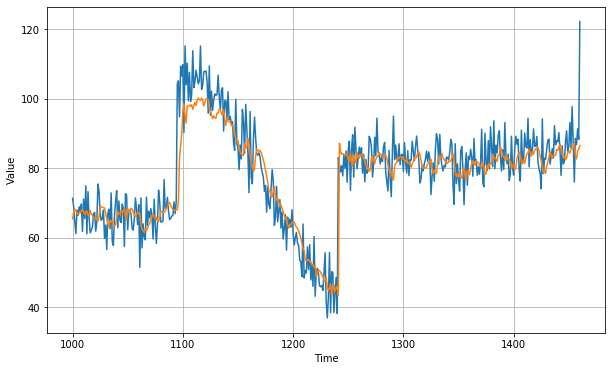

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.0222244

<Figure size 432x288 with 0 Axes>

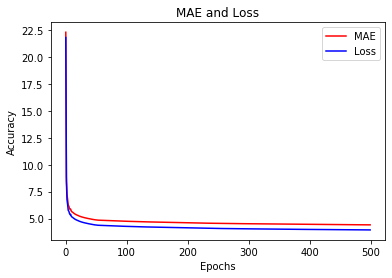

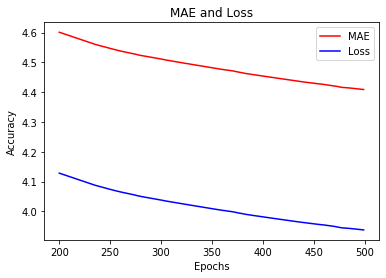

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history["mae"]
loss=history.history["loss"]

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, "r")
plt.plot(epochs, loss, "b")
plt.title("MAE and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, "r")
plt.plot(epochs_zoom, loss_zoom, "b")
plt.title("MAE and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

## Lesson 3

In [12]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [13]:
!/miniconda3/envs/tensorflow/bin/wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2019-09-15 10:59:23--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com... 172.217.10.112
Connecting to storage.googleapis.com|172.217.10.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: '/tmp/sunspots.csv'

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.05s   

2019-09-15 10:59:23 (1.48 MB/s) - '/tmp/sunspots.csv' saved [70827/70827]



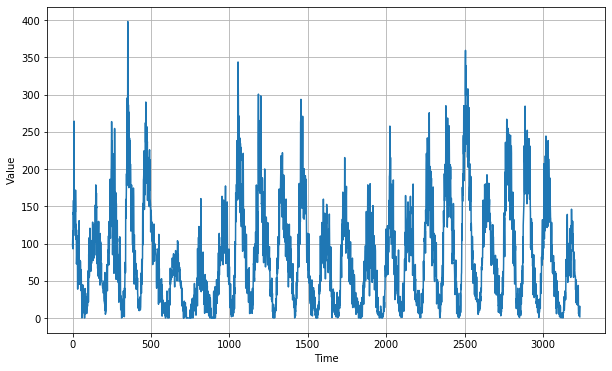

In [14]:
import csv
time_step = []
sunspots = []

with open("/tmp/sunspots.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter = ",")
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize = (10, 6))
plot_series(time, series)

In [15]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [17]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape = [window_size], activation = "relu"), 
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss = "mse", optimizer = tf.keras.optimizers.SGD(lr = 1e-7, momentum = 0.9))
model.fit(dataset,epochs = 100,verbose = 0)

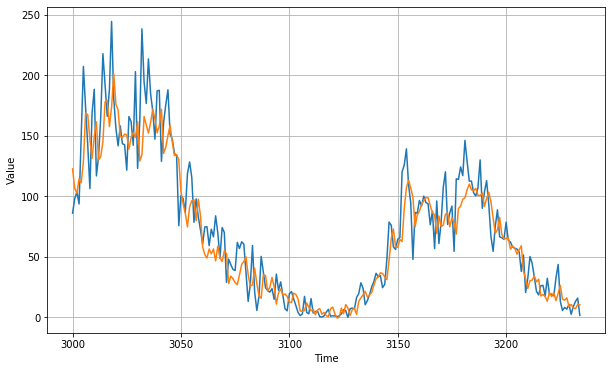

In [18]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

15.477862

## Lesson 5

In [20]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [21]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [22]:
!/miniconda3/envs/tensorflow/bin/wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2019-09-15 11:02:40--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com... 172.217.10.112
Connecting to storage.googleapis.com|172.217.10.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: '/tmp/sunspots.csv'

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.05s   

2019-09-15 11:02:41 (1.33 MB/s) - '/tmp/sunspots.csv' saved [70827/70827]



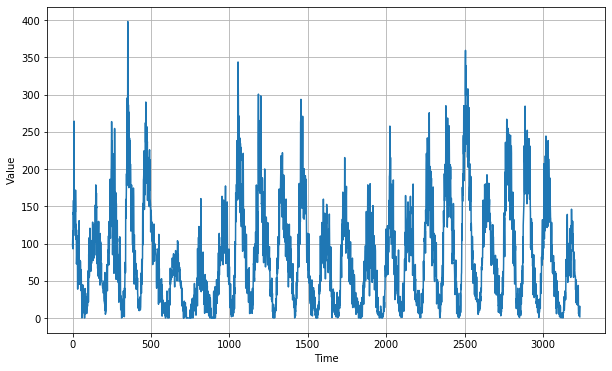

In [23]:
import csv
time_step = []
sunspots = []

with open("/tmp/sunspots.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter = ",")
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize = (10, 6))
plot_series(time, series)

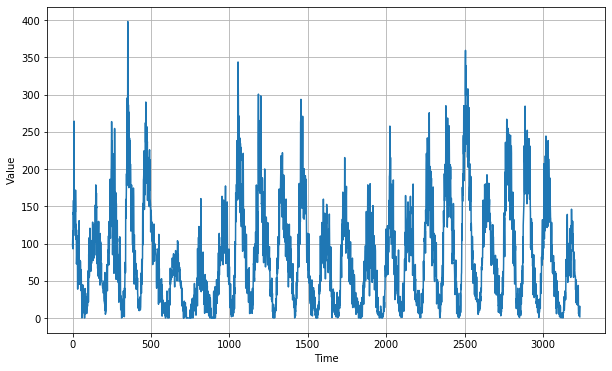

In [24]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize = (10, 6))
plot_series(time, series)

In [25]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [26]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [27]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                           strides = 1, padding = "causal",
                           activation = "relu", input_shape = [None, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.Dense(30, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 23s 2s/step - loss: 80.3072 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 6s 499ms/step - loss: 78.5038 - mae: 78.5937
Epoch 3/100
12/12 [==============================] - 6s 461ms/step - loss: 75.8321 - mae: 75.9399
Epoch 4/100
12/12 [==============================] - 6s 505ms/step - loss: 72.6364 - mae: 72.7566
Epoch 5/100
12/12 [==============================] - 5s 456ms/step - loss: 69.1225 - mae: 69.2522
Epoch 6/100
12/12 [==============================] - 6s 481ms/step - loss: 65.4573 - mae: 65.5938
Epoch 7/100
12/12 [==============================] - 6s 513ms/step - loss: 61.8589 - mae: 62.0000
Epoch 8/100
12/12 [==============================] - 6s 518ms/step - loss: 58.4736 - mae: 58.6180
Epoch 9/100
12/12 [==============================] - 6s 499ms/step - loss: 55.3957 - mae: 55.5447
Epoch 10/100
12/12

Epoch 52/100
12/12 [==============================] - 4s 293ms/step - loss: 21.9745 - mae: 22.4011
Epoch 53/100
12/12 [==============================] - 3s 274ms/step - loss: 21.3729 - mae: 21.8031
Epoch 54/100
12/12 [==============================] - 3s 277ms/step - loss: 21.5153 - mae: 21.9359
Epoch 55/100
12/12 [==============================] - 3s 279ms/step - loss: 21.0203 - mae: 21.4383
Epoch 56/100
12/12 [==============================] - 3s 281ms/step - loss: 20.6489 - mae: 21.0742
Epoch 57/100
12/12 [==============================] - 4s 343ms/step - loss: 20.7971 - mae: 21.2414
Epoch 58/100
12/12 [==============================] - 4s 325ms/step - loss: 20.6975 - mae: 21.0900
Epoch 59/100
12/12 [==============================] - 3s 215ms/step - loss: 20.5550 - mae: 20.9893
Epoch 60/100
12/12 [==============================] - 3s 287ms/step - loss: 19.8482 - mae: 20.2810
Epoch 61/100
12/12 [==============================] - 4s 324ms/step - loss: 20.1562 - mae: 20.6018
Epoch 62/1

[1e-08, 0.0001, 0, 60]

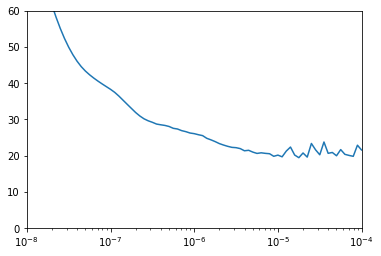

In [29]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set  =  windowed_dataset(x_train, window_size = 60, batch_size = 100, shuffle_buffer = shuffle_buffer_size)
model  =  tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 60, kernel_size = 5,
                           strides = 1, padding = "causal",
                           activation = "relu", input_shape = [None, 1]),
    tf.keras.layers.LSTM(60, return_sequences = True),
    tf.keras.layers.LSTM(60, return_sequences = True),
    tf.keras.layers.Dense(30, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer  =  tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
history  =  model.fit(train_set,epochs = 500)

Epoch 1/500
30/30 [==============================] - 11s 355ms/step - loss: 37.8898 - mae: 38.6062
Epoch 2/500
30/30 [==============================] - 4s 144ms/step - loss: 24.3138 - mae: 24.8472
Epoch 3/500
30/30 [==============================] - 4s 143ms/step - loss: 21.0373 - mae: 21.5409
Epoch 4/500
30/30 [==============================] - 4s 131ms/step - loss: 20.2810 - mae: 20.7735
Epoch 5/500
30/30 [==============================] - 4s 130ms/step - loss: 19.6641 - mae: 20.1639
Epoch 6/500
30/30 [==============================] - 4s 135ms/step - loss: 19.4450 - mae: 19.9453
Epoch 7/500
30/30 [==============================] - 4s 149ms/step - loss: 18.7866 - mae: 19.2646
Epoch 8/500
30/30 [==============================] - 4s 140ms/step - loss: 18.6434 - mae: 19.1347
Epoch 9/500
30/30 [==============================] - 4s 146ms/step - loss: 18.3243 - mae: 18.8121
Epoch 10/500
30/30 [==============================] - 4s 144ms/step - loss: 18.0341 - mae: 18.5152
Epoch 11/500
30/30

Epoch 53/500
30/30 [==============================] - 4s 127ms/step - loss: 16.8160 - mae: 17.3006
Epoch 54/500
30/30 [==============================] - 4s 124ms/step - loss: 16.7208 - mae: 17.2035
Epoch 55/500
30/30 [==============================] - 5s 154ms/step - loss: 16.7086 - mae: 17.1935
Epoch 56/500
30/30 [==============================] - 4s 150ms/step - loss: 16.8368 - mae: 17.3130
Epoch 57/500
30/30 [==============================] - 4s 139ms/step - loss: 16.7349 - mae: 17.2154
Epoch 58/500
30/30 [==============================] - 4s 131ms/step - loss: 16.7472 - mae: 17.2233
Epoch 59/500
30/30 [==============================] - 4s 134ms/step - loss: 16.6850 - mae: 17.1671
Epoch 60/500
30/30 [==============================] - 4s 138ms/step - loss: 16.7385 - mae: 17.2141
Epoch 61/500
30/30 [==============================] - 4s 130ms/step - loss: 16.6884 - mae: 17.1705
Epoch 62/500
30/30 [==============================] - 4s 131ms/step - loss: 16.7139 - mae: 17.1930
Epoch 63/5

30/30 [==============================] - 4s 133ms/step - loss: 16.0554 - mae: 16.5373
Epoch 136/500
30/30 [==============================] - 4s 131ms/step - loss: 16.0377 - mae: 16.5159
Epoch 137/500
30/30 [==============================] - 4s 131ms/step - loss: 16.0475 - mae: 16.5287
Epoch 138/500
30/30 [==============================] - 4s 129ms/step - loss: 16.0280 - mae: 16.5072
Epoch 139/500
30/30 [==============================] - 4s 130ms/step - loss: 16.0294 - mae: 16.5086
Epoch 140/500
30/30 [==============================] - 4s 129ms/step - loss: 16.0219 - mae: 16.5007
Epoch 141/500
30/30 [==============================] - 4s 136ms/step - loss: 16.0274 - mae: 16.5089
Epoch 142/500
30/30 [==============================] - 4s 135ms/step - loss: 16.0115 - mae: 16.4936
Epoch 143/500
30/30 [==============================] - 4s 134ms/step - loss: 15.9989 - mae: 16.4780
Epoch 144/500
30/30 [==============================] - 4s 133ms/step - loss: 16.0280 - mae: 16.5075
Epoch 145/500


30/30 [==============================] - 4s 132ms/step - loss: 15.7357 - mae: 16.2169
Epoch 218/500
30/30 [==============================] - 4s 134ms/step - loss: 15.7549 - mae: 16.2381
Epoch 219/500
30/30 [==============================] - 4s 147ms/step - loss: 15.7543 - mae: 16.2377
Epoch 220/500
30/30 [==============================] - 4s 146ms/step - loss: 15.7266 - mae: 16.2093
Epoch 221/500
30/30 [==============================] - 4s 141ms/step - loss: 15.7216 - mae: 16.2044
Epoch 222/500
30/30 [==============================] - 4s 140ms/step - loss: 15.7117 - mae: 16.1941
Epoch 223/500
30/30 [==============================] - 4s 146ms/step - loss: 15.6987 - mae: 16.1806
Epoch 224/500
30/30 [==============================] - 4s 133ms/step - loss: 15.6949 - mae: 16.1767
Epoch 225/500
30/30 [==============================] - 4s 135ms/step - loss: 15.6940 - mae: 16.1761
Epoch 226/500
30/30 [==============================] - 4s 135ms/step - loss: 15.6965 - mae: 16.1789
Epoch 227/500


30/30 [==============================] - 6s 213ms/step - loss: 15.3845 - mae: 15.8617
Epoch 300/500
30/30 [==============================] - 6s 215ms/step - loss: 15.3793 - mae: 15.8565
Epoch 301/500
30/30 [==============================] - 6s 215ms/step - loss: 15.3688 - mae: 15.8459
Epoch 302/500
30/30 [==============================] - 7s 217ms/step - loss: 15.3658 - mae: 15.8428
Epoch 303/500
30/30 [==============================] - 7s 236ms/step - loss: 15.3615 - mae: 15.8384
Epoch 304/500
30/30 [==============================] - 7s 225ms/step - loss: 15.3575 - mae: 15.8345
Epoch 305/500
30/30 [==============================] - 7s 242ms/step - loss: 15.3469 - mae: 15.8238
Epoch 306/500
30/30 [==============================] - 8s 261ms/step - loss: 15.3401 - mae: 15.8171
Epoch 307/500
30/30 [==============================] - 9s 285ms/step - loss: 15.3321 - mae: 15.8091
Epoch 308/500
30/30 [==============================] - 6s 207ms/step - loss: 15.3279 - mae: 15.8049
Epoch 309/500


30/30 [==============================] - 6s 198ms/step - loss: 15.0282 - mae: 15.5075
Epoch 382/500
30/30 [==============================] - 6s 195ms/step - loss: 15.0099 - mae: 15.4895
Epoch 383/500
30/30 [==============================] - 6s 201ms/step - loss: 14.9856 - mae: 15.4656
Epoch 384/500
30/30 [==============================] - 6s 209ms/step - loss: 14.9573 - mae: 15.4376
Epoch 385/500
30/30 [==============================] - 6s 199ms/step - loss: 14.9367 - mae: 15.4171
Epoch 386/500
30/30 [==============================] - 6s 199ms/step - loss: 14.9159 - mae: 15.3959
Epoch 387/500
30/30 [==============================] - 6s 211ms/step - loss: 14.9137 - mae: 15.3938
Epoch 388/500
30/30 [==============================] - 8s 252ms/step - loss: 14.9068 - mae: 15.3868
Epoch 389/500
30/30 [==============================] - 7s 250ms/step - loss: 14.9138 - mae: 15.3941
Epoch 390/500
30/30 [==============================] - 6s 204ms/step - loss: 14.9152 - mae: 15.3957
Epoch 391/500


30/30 [==============================] - 4s 133ms/step - loss: 14.7641 - mae: 15.2457
Epoch 464/500
30/30 [==============================] - 4s 134ms/step - loss: 14.5565 - mae: 15.0293
Epoch 465/500
30/30 [==============================] - 4s 134ms/step - loss: 14.6797 - mae: 15.1630
Epoch 466/500
30/30 [==============================] - 4s 133ms/step - loss: 14.6317 - mae: 15.1074
Epoch 467/500
30/30 [==============================] - 4s 135ms/step - loss: 14.6677 - mae: 15.1497
Epoch 468/500
30/30 [==============================] - 4s 133ms/step - loss: 14.6397 - mae: 15.1171
Epoch 469/500
30/30 [==============================] - 4s 132ms/step - loss: 14.6388 - mae: 15.1182
Epoch 470/500
30/30 [==============================] - 4s 135ms/step - loss: 14.6397 - mae: 15.1202
Epoch 471/500
30/30 [==============================] - 4s 134ms/step - loss: 14.6435 - mae: 15.1246
Epoch 472/500
30/30 [==============================] - 5s 150ms/step - loss: 14.6372 - mae: 15.1182
Epoch 473/500


In [31]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

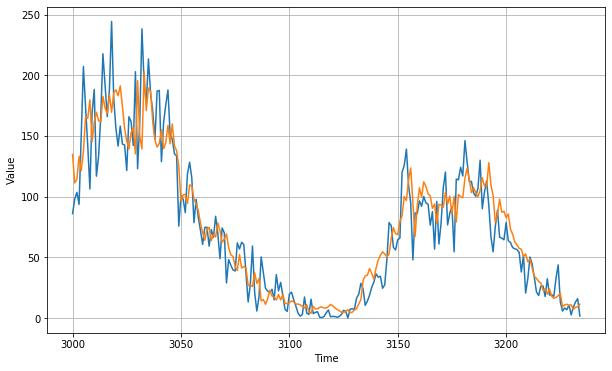

In [32]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [33]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.622693

<Figure size 432x288 with 0 Axes>

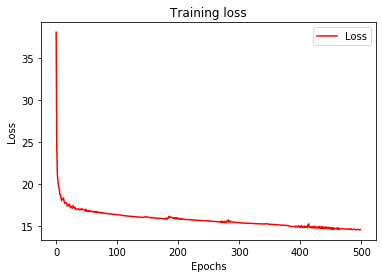

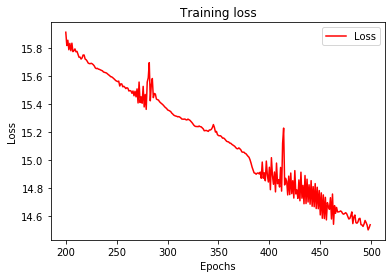

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history.history["loss"]

epochs = range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, "r")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, "r")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [35]:
print(rnn_forecast)

[134.71724   111.213554  114.379814  133.10391   121.4103    136.95349
 165.59717   164.44725   179.76688   145.17406   161.2163    169.48389
 162.54254   161.39186   182.61162   172.96156   168.38338   183.87999
 169.49129   185.47827   187.94824   183.07036   191.19995   174.23137
 156.2904    145.67105   139.1312    153.00186   156.888     135.22902
 195.56604   149.9592    139.29207   202.78787   170.8776    189.51064
 186.68309   161.28868   146.51212   140.82617   143.7628    155.11635
 139.4671    144.44121   158.72617   143.49983   159.81851   141.8278
 137.76839   124.858925   96.40654   101.341606  101.96003    94.3717
 109.63624   108.67761    98.03882    93.73997    88.57449    78.19259
  70.3014     64.011215   72.65362    74.71532    63.704197   69.00242
  66.7631     78.36193    71.988655   62.351673   64.9039     69.25053
  57.99516    52.1649     50.604355   42.35011    39.07319    52.361935
  41.107975   42.397453   41.165188   26.7376     27.10396    25.942581
  37.2